Получаем данные и импортим необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd

wine_train = pd.read_csv('../../ML-API/python-app/winequality-red.csv', sep=";")
wine_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Разбиваем на матрицу объектов-признаков и вектор правильных ответов

In [2]:
X = wine_train.drop(['quality'], axis='columns').values
y = wine_train['quality'].values

Применяем отложенную выборку. Т.е. разделяем предоставленные данные на обучающие и валидационные(80/20)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, random_state=9, test_size=0.2, stratify=y)

Подготоваливаем матрицу объектов-признаков

In [4]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)

In [5]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss

def print_prediction_assessment(predictions, y_val):
    acc = accuracy_score(y_val, predictions)
    f1 = f1_score(y_val, predictions, average="weighted")
    cm = confusion_matrix(y_val, predictions)
    print('ACCURACY:    ', acc * 100,'%', '\nf1-score:   ', f1 * 100,'%')
    print(cm)

Построим модель используя алгоритм Метод ближайших соседей.

In [6]:
from sklearn.neighbors import KNeighborsClassifier

knnc = KNeighborsClassifier(n_neighbors=11)
knnc = knnc.fit(X_train, y_train)

predictions = knnc.predict(X_val)
print_prediction_assessment(predictions, y_val)

ACCURACY:     60.0 % 
f1-score:    58.12677456476164 %
[[  0   0   2   0   0   0]
 [  0   0   6   5   0   0]
 [  0   1 101  31   3   0]
 [  0   0  41  77  10   0]
 [  0   1   2  23  14   0]
 [  0   0   0   1   2   0]]


C:\Users\ali_2\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Настроим число соседей на 5кратной кросс-валидации. 

In [7]:
from sklearn.model_selection import GridSearchCV, cross_val_score

knn_params = {'n_neighbors': range(2,100)}
knn_grid = GridSearchCV(knnc, knn_params, cv=5, n_jobs=-1, verbose=True)

knn_grid.fit(X_train, y_train)
knn_grid.best_params_

Fitting 5 folds for each of 98 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:   30.8s finished


{'n_neighbors': 35}

Построение логистической функции

Text(0.5,0,'n_neighbors')

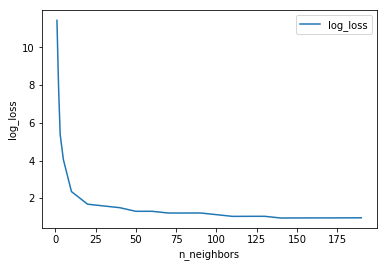

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline

ll_scores  = []

n_neighb = [1, 2, 3, 5] + list(range(10, 200, 10))

for k in n_neighb:

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    ll_scores.append(log_loss(y_val, knn.predict_proba(X_val)))

plt.plot(n_neighb, ll_scores, label="log_loss")
plt.legend();
plt.ylabel('log_loss')
plt.xlabel('n_neighbors')

In [9]:
# 59% кол-во правильных ответов на кросс-валидации и 67% на отложенной выборке
knn_grid.best_score_ * 100

58.639562157935885

In [10]:
accuracy_score(y_val, knn_grid.predict(X_val)) * 100

61.25000000000001

Построим модель используя алгоритм Дерева решений. Также применим адаптивный бустинг для Дерева решений.

In [11]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

print("DecisionTreeClassifier, criterion=entropy")
dt1 = DecisionTreeClassifier(criterion='entropy', random_state=12345)
dt1 = dt1.fit(X_train, y_train)

predictions1 = dt1.predict(X_val)
print_prediction_assessment(predictions1, y_val)

print("DecisionTreeClassifier, criterion=gini")
dt2 = DecisionTreeClassifier(criterion='gini', random_state=1337)
dt2 = dt2.fit(X_train, y_train)

predictions2 = dt2.predict(X_val)
print_prediction_assessment(predictions2, y_val)

print("AdaBoostClassifier")
abdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=11, random_state=228),
                          algorithm="SAMME",
                          random_state=228)

abdt.fit(X_train, y_train)
pred = abdt.predict(X_val)
print_prediction_assessment(pred, y_val)

DecisionTreeClassifier, criterion=entropy
ACCURACY:     62.5 % 
f1-score:    62.34074029787537 %
[[ 0  0  2  0  0  0]
 [ 1  1  5  4  0  0]
 [ 1  3 90 37  5  0]
 [ 2  2 24 86 12  2]
 [ 0  0  2 15 23  0]
 [ 0  0  0  1  2  0]]
DecisionTreeClassifier, criterion=gini
ACCURACY:     65.0 % 
f1-score:    65.35429517416546 %
[[ 0  0  1  1  0  0]
 [ 1  3  2  4  0  1]
 [ 0  4 94 33  4  1]
 [ 0  5 25 87 11  0]
 [ 0  1  2 10 24  3]
 [ 0  0  0  2  1  0]]
AdaBoostClassifier
ACCURACY:     71.875 % 
f1-score:    70.04200770274099 %
[[  0   0   2   0   0   0]
 [  1   0   5   5   0   0]
 [  0   0 110  25   1   0]
 [  0   0  18 101   9   0]
 [  0   0   0  20  19   1]
 [  0   0   0   2   1   0]]


C:\Users\ali_2\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Настроим максимальную глубину дерева на 5кратной кросс-валидации.

In [12]:
from sklearn.model_selection import GridSearchCV, cross_val_score

tree_params1 = {'max_depth': range(1,50)}
tree_grid1 = GridSearchCV(dt1, tree_params1, cv=5, verbose=True)
tree_grid1.fit(X_train, y_train)
tree_grid1.best_params_

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:    8.5s finished


{'max_depth': 17}

In [13]:
# 60% кол-во правильных ответов на кросс-валидации и 62.5% на отложенной выборке
tree_grid1.best_score_ * 100

59.73416731821736

In [14]:
accuracy_score(y_val, tree_grid1.predict(X_val)) * 100

62.5

In [15]:
tree_params2 = {'max_depth': range(1,50)}
tree_grid2 = GridSearchCV(dt2, tree_params2, cv=5, verbose=True)
tree_grid2.fit(X_train, y_train)
tree_grid2.best_params_

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:    4.4s finished


{'max_depth': 16}

In [16]:
# 58% кол-во правильных ответов на кросс-валидации и 68.125% на отложенной выборке
tree_grid2.best_score_ * 100

58.483189992181394

In [17]:
accuracy_score(y_val, tree_grid2.predict(X_val)) * 100

68.125

Построим модель используя алгоритм Случайный лес.

In [18]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=64, max_depth=16, random_state=100)
rfc = rfc.fit(X_train, y_train)

predictions4 = rfc.predict(X_val)
print_prediction_assessment(predictions4, y_val)

ACCURACY:     70.9375 % 
f1-score:    69.30121574026015 %
[[  0   1   1   0   0   0]
 [  1   1   5   4   0   0]
 [  0   0 113  21   2   0]
 [  0   0  21  97  10   0]
 [  0   0   2  21  16   1]
 [  0   0   0   2   1   0]]


Настроим число деревьев на 5кратной кросс-валидации.

In [19]:
tree_params4 = {'n_estimators': range(60,100)}
tree_grid4 = GridSearchCV(rfc, tree_params4, cv=5, verbose=True)
tree_grid4.fit(X_train, y_train)
tree_grid4.best_params_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.3min finished


{'n_estimators': 96}

Text(0.5,0,'n_estimators')

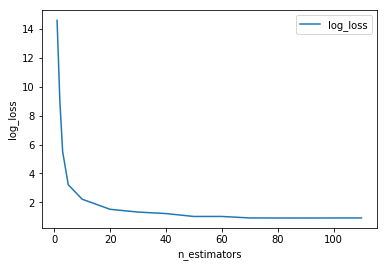

In [20]:
ll_scores = []

n_estim = [1, 2, 3, 5] + list(range(10, 120, 10))

for k in n_estim:

    rf = RandomForestClassifier(n_estimators=k, max_depth=16, random_state=100)
    rf.fit(X_train, y_train)
    ll_scores.append(log_loss(y_val, rf.predict_proba(X_val)))

plt.plot(n_estim, ll_scores, label="log_loss")
plt.legend();
plt.ylabel('log_loss')
plt.xlabel('n_estimators')

In [21]:
# 68% кол-во правильных ответов на кросс-валидации и 73% на отложенной выборке
tree_grid4.best_score_ * 100

67.94370602032838

In [22]:
accuracy_score(y_val, tree_grid4.predict(X_val)) * 100

73.125

Построим модель используя алгоритм Градиентный бустинг.

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(random_state=228)
gbm.fit(X_train, y_train)

pred = gbm.predict(X_val)
print_prediction_assessment(pred, y_val)

ACCURACY:     69.6875 % 
f1-score:    68.45878731508547 %
[[  0   1   1   0   0   0]
 [  0   2   6   3   0   0]
 [  0   1 113  22   0   0]
 [  0   0  26  91   9   2]
 [  0   0   2  20  17   1]
 [  0   0   0   1   2   0]]


C:\Users\ali_2\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Настроим число деревьев на 5кратной кросс-валидации.

In [24]:
gbm_params = {'n_estimators': range(100,120)}
gbm_grid = GridSearchCV(gbm, gbm_params, cv=5, n_jobs=-1, verbose=True)
gbm_grid.fit(X_train, y_train)
gbm_grid.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


{'n_estimators': 106}

In [25]:
# 65% кол-во правильных ответов на кросс-валидации и 70% на отложенной выборке
gbm_grid.best_score_ * 100

64.97263487099296

In [27]:
accuracy_score(y_val, gbm_grid.predict(X_val)) * 100

70.0

Сравнение приведенных выше алгоритмов

In [36]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('RFC', RandomForestClassifier()))

In [37]:
from sklearn.model_selection import KFold

results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = KFold(n_splits=10, random_state=7)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

KNN: 0.548819 (0.061008)
CART: 0.587894 (0.047170)
ABC: 0.510531 (0.106896)
GBC: 0.636399 (0.037071)
RFC: 0.652061 (0.042339)


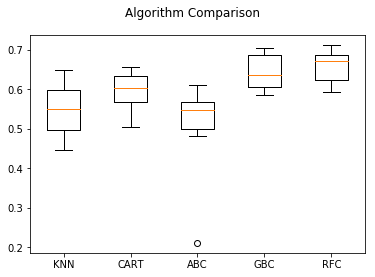

In [35]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Исходя из полученных результатов, что среднее значение доли полученных результатов наиболее высоко для алгоритма Случайный лес. В связи с этим в качестве используемой (рабочей) модели будет использован этот алгоритм.